In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt
import modelutils_v2 as modelutils
import copy

In [2]:
def div0( self,a, b ):
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0]
    MOVE ME OUT TO THE GLOBAL SCOPE
    """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
        c[ ~ np.isfinite( c )] = 0  # -inf inf NaN
    return c

npeople = 100
tsteps = 14
ax=None
ntrials = 30
action = None
nlocations = 10
ntests=10


ff = 40*[100]+10*[100]
lambda_ = 40*[5e-3]+ 10*[1e-2]
homelocs = np.zeros([nlocations,npeople])
for person_idx in range(npeople):
    homelocs[np.random.choice(np.arange(nlocations)),person_idx]=1.

init_state = modelutils.state(homelocs,quarantine=True)#lambda_=lambda_) 

#temporarily endow "full knowledge" FOR DEBUGGING ONLY. Does feeding in the actual hidden state as the partially-observed state fix things?
init_state.action = np.ones(npeople)

In [3]:
forecast_output = init_state.forecast_v2(ntrials=1000)

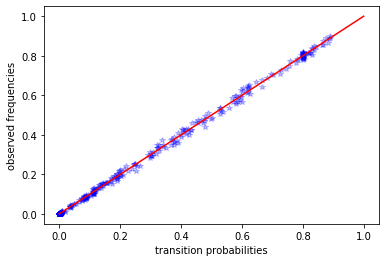

In [5]:
txn_probs = []
obs_freqs = []  #the lists to hold the x-y values we're plotting against

for person_idx in range(npeople):
    partial_txn_mat = np.squeeze(forecast_output[0][person_idx])
    actual_txn_mat = forecast_output[1][person_idx]
    
    nonzero_indices = np.where(np.sum(partial_txn_mat,axis=-1)!=0)[0]
    partial_txn_mat[nonzero_indices,:] = np.squeeze(np.divide(partial_txn_mat[nonzero_indices,:],np.expand_dims(np.sum(partial_txn_mat[nonzero_indices,:],axis=-1),axis=-1))[:,None])
    
    
    txn_probs+=list(actual_txn_mat[nonzero_indices,:].flatten())
    obs_freqs+=list(partial_txn_mat[nonzero_indices,:].flatten())
    

    

plt.plot(txn_probs,obs_freqs,'*b',alpha=0.25)
plt.xlabel('transition probabilities')
plt.ylabel('observed frequencies')
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100),'-r')
plt.savefig('forecast.png')